In [1]:
import sys 
sys.path.append('../scripts/')
from robot import *
from scipy.stats import multivariate_normal
import random #追加
import copy

In [2]:
class Particle: 
    def __init__(self, init_pose, weight):
        self.pose = init_pose
        self.weight = weight
        
    def motion_update(self, nu, omega, time, noise_rate_pdf): 
        ns = noise_rate_pdf.rvs()
        pnu = nu + ns[0]*math.sqrt(abs(nu)/time) + ns[1]*math.sqrt(abs(omega)/time)
        pomega = omega + ns[2]*math.sqrt(abs(nu)/time) + ns[3]*math.sqrt(abs(omega)/time)
        self.pose = IdealRobot.state_transition(pnu, pomega, time, self.pose)
        
    def observation_update(self, observation, envmap, distance_dev_rate, direction_dev):  #変更
        for d in observation:
            obs_pos = d[0]
            obs_id = d[1]
            
            ##パーティクルの位置と地図からランドマークの距離と方角を算出##
            pos_on_map = envmap.landmarks[obs_id].pos
            particle_suggest_pos = IdealCamera.relative_polar_pos(self.pose, pos_on_map)
            
            ##尤度の計算##
            distance_dev = distance_dev_rate*particle_suggest_pos[0]
            cov = np.diag(np.array([distance_dev**2, direction_dev**2]))
            self.weight *= multivariate_normal(mean=particle_suggest_pos, cov=cov).pdf(obs_pos)

In [3]:
class Mcl: 
    def __init__(self, envmap, init_pose, num, motion_noise_stds, distance_dev_rate=0.14, direction_dev=0.05): #特に変更なし
        self.particles = [Particle(init_pose, 1.0/num) for i in range(num)]
        self.map = envmap
        self.distance_dev_rate = distance_dev_rate
        self.direction_dev = direction_dev

        v = motion_noise_stds
        c = np.diag([v["nn"]**2, v["no"]**2, v["on"]**2, v["oo"]**2])
        self.motion_noise_rate_pdf = multivariate_normal(cov=c)
        
        self.ml = self.particles[0]
        self.alphas = {} #alpha値の記録（ランドマークの観測数ごと）
        
    def set_ml(self): #追加
        i = np.argmax([p.weight for p in self.particles])
        self.ml = self.particles[i]
        
    def motion_update(self, nu, omega, time): 
        for p in self.particles: p.motion_update(nu, omega, time, self.motion_noise_rate_pdf)
            
    def observation_update(self, observation): ###mclalpha
        for p in self.particles:
            p.observation_update(observation, self.map, self.distance_dev_rate, self.direction_dev) 
        
        #alpha値の記録
        alpha = sum([p.weight for p in self.particles])
        obsnum = len(observation)
        if not obsnum in self.alphas: self.alphas[obsnum] = []
        self.alphas[obsnum].append(alpha)
            
        self.set_ml()
        self.resampling() #ここで重みの合計は1になる
            
    def resampling(self): 
        ws = [e.weight for e in self.particles]
        
        #重みの和がゼロに丸め込まれるとサンプリングできなくなるので小さな数を足しておく
        if sum(ws) < 1e-100: ws = [e + 1e-100 for e in ws]
        
        # パーティクルのリストから、weightsのリストの重みに比例した確率で、num個選ぶ    
        ps = random.choices(self.particles, weights=ws, k=len(self.particles))  
        
        # 選んだリストからパーティクルを取り出し、重みを均一に
        self.particles = [copy.deepcopy(e) for e in ps]
        for p in self.particles: p.weight = 1.0/len(self.particles)
        
    def draw(self, ax, elems):  
        xs = [p.pose[0] for p in self.particles]
        ys = [p.pose[1] for p in self.particles]
        vxs = [math.cos(p.pose[2])*p.weight*len(self.particles) for p in self.particles] #重みを要素に反映
        vys = [math.sin(p.pose[2])*p.weight*len(self.particles) for p in self.particles]  #重みを要素に反映
        elems.append(ax.quiver(xs, ys, vxs, vys, \
                               angles='xy', scale_units='xy', scale=1.5, color="blue", alpha=0.5)) #変更

In [4]:
class MclAgent(Agent): 
    def __init__(self, time_interval, nu, omega, particle_pose, envmap, particle_num=100, \
                motion_noise_stds={"nn":0.19, "no":0.001, "on":0.13, "oo":0.2}): #2行目にenvmapを追加
        super().__init__(nu, omega)
        self.pf = Mcl(envmap, particle_pose, particle_num, motion_noise_stds) #envmapを追加
        self.time_interval = time_interval
        
        self.prev_nu = 0.0
        self.prev_omega = 0.0
        
    def decision(self, observation=None): 
        self.pf.motion_update(self.prev_nu, self.prev_omega, self.time_interval)
        self.prev_nu, self.prev_omega = self.nu, self.omega
        self.pf.observation_update(observation)
        return self.nu, self.omega
        
    def draw(self, ax, elems):
        self.pf.draw(ax, elems)
        x, y, t = self.pf.ml.pose #以下追加
        s = "({:.2f}, {:.2f}, {})".format(x,y,int(t*180/math.pi)%360)
        elems.append(ax.text(x, y+0.1, s, fontsize=8))

<IPython.core.display.Javascript object>


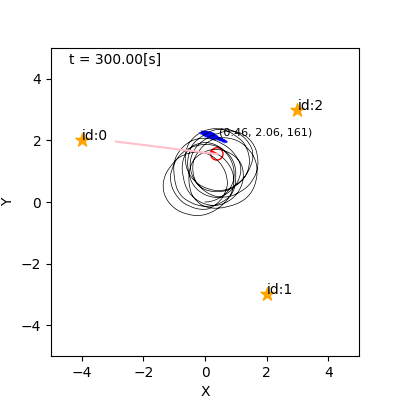

In [5]:
if __name__ == '__main__': 
    time_interval = 0.1
    world = World(300, time_interval) 

    ## 地図を生成して3つランドマークを追加 ##
    m = Map()                                  
    m.append_landmark(Landmark(-4,2))
    m.append_landmark(Landmark(2,-3))
    m.append_landmark(Landmark(3,3))
    world.append(m)          

    ## ロボットを作る ##
    a = MclAgent(time_interval, 0.2, 10.0/180*math.pi, np.array([0, 0, 0]).T, m, particle_num=100) 
    r = Robot(np.array([0,0,0]).T, sensor=Camera(m), agent=a, color="red")
    world.append(r)

    world.draw()

In [7]:
for num in a.pf.alphas: ###mclalpharesult
    print("landmarks:", num, "particles:", len(a.pf.particles), "min:", min(a.pf.alphas[num]), "max:", max(a.pf.alphas[num]))

landmarks: 2 particles: 100 min: 0.30975844678458514 max: 20.53341319561884
landmarks: 0 particles: 100 min: 1.0000000000000007 max: 1.0000000000000007
landmarks: 1 particles: 100 min: 0.012836763797112119 max: 8.863088948593317


<IPython.core.display.Javascript object>


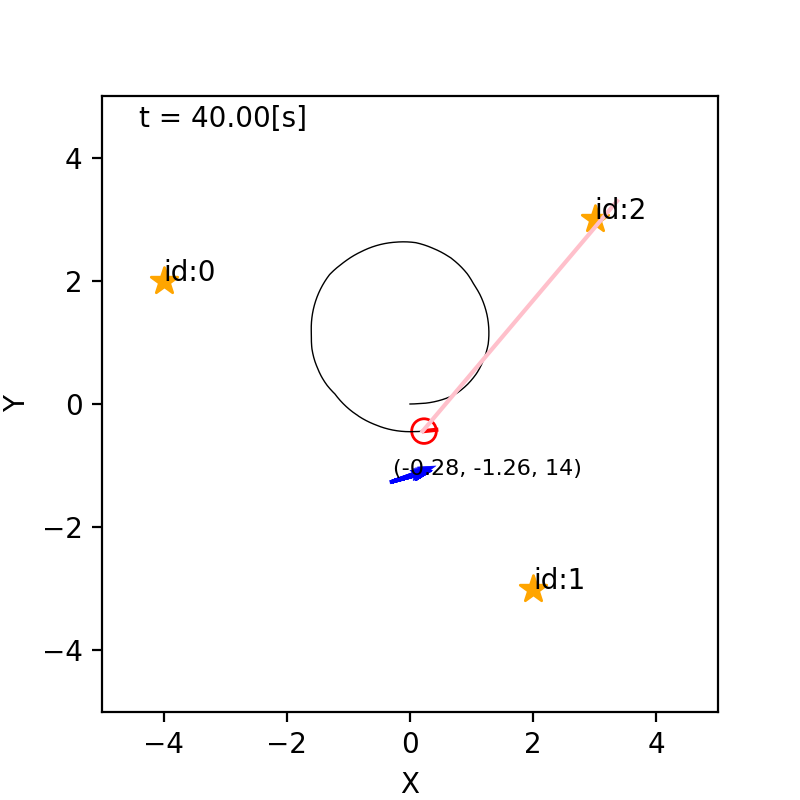

In [26]:
if __name__ == '__main__': 
    time_interval = 0.1
    world = World(40, time_interval) 

    ## 地図を生成して3つランドマークを追加 ##
    m = Map()                                  
    m.append_landmark(Landmark(-4,2))
    m.append_landmark(Landmark(2,-3))
    m.append_landmark(Landmark(3,3))
    world.append(m)          

    ## ロボットを作る ##
    a = MclAgent(time_interval, 0.2, 10.0/180*math.pi, np.array([-4, -4, 0]).T, m, particle_num=100) 
    r = Robot(np.array([0,0,0]).T, sensor=Camera(m), agent=a, color="red")
    world.append(r)

    world.draw()

In [27]:
for num in a.pf.alphas: ###mclalpharesult2
    print("landmarks:", num, "particles:", len(a.pf.particles), "min:", min(a.pf.alphas[num]), "max:", max(a.pf.alphas[num]))

landmarks: 1 particles: 100 min: 6.471623836673905e-170 max: 6.255390567637762
landmarks: 2 particles: 100 min: 3.313072754632013e-110 max: 0.01469517382328725
landmarks: 0 particles: 100 min: 1.0000000000000007 max: 1.0000000000000007


In [28]:
a.pf.alphas

{1: [0.00032402076461969173,
  7.046428488644562e-05,
  0.00017064587735780926,
  9.158705317833497e-06,
  1.968680355490866e-05,
  0.0006401168290646057,
  0.00022665466016988828,
  5.72744823251913e-05,
  7.462145449433408e-05,
  0.00024275340211710905,
  4.0428601919174436e-05,
  0.0005042313865505211,
  5.6729490009801505e-05,
  0.00014476893194111706,
  0.00029134685415903576,
  0.0001461651418730924,
  0.0001516281209775659,
  0.00011077384340013404,
  6.275306786289601e-05,
  6.418959960173953e-05,
  0.0003228754078108091,
  9.862484281753894e-05,
  9.284986892505957e-05,
  4.237732292205591e-05,
  4.92916795653014e-05,
  1.446063149057754e-06,
  5.203043935683543e-06,
  0.00020152973311023697,
  6.872848752096358e-06,
  3.5229905305961053e-05,
  2.6749670522620615e-06,
  2.4256293151805707e-05,
  9.98278853596611e-06,
  2.1466960768422276e-05,
  3.1629526399473854e-05,
  0.00018719182635163148,
  0.00012572022907462446,
  0.0003605578653917516,
  5.233931362140015e-05,
  6.6451